# Sparse GPLVM

We combine Titsias' variational sparse GPs with GPLVMs

In [8]:
%config InlineBackend.figure_format = 'svg'
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import pandas as pd

from utils import rbf
from sparse_gplvm import free_energy, get_predictive_variational_gp, gp_log_prob, fit_inducing_points, fit_latents

DATA_DIR = "../data/gplvm/"
IMG_FOLDER = "../images/sparse_gplvm/"

In [2]:
latent_dim = 2

# oil dataset
Y = pd.read_csv(DATA_DIR + '/train_data.txt', header=None, sep='\s+').values[:500, :]
labels = (pd.read_csv(DATA_DIR + '/labels.txt', header=None, sep='\s+').values[:500, :]).astype(np.int)

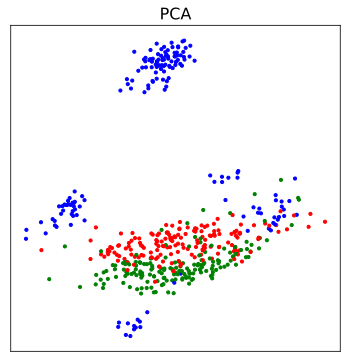

In [3]:
plt.figure(figsize = (13, 6))
plt.subplot(121)
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(Y)
X_pca = X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('PCA', fontsize=16)
plt.xticks([])
plt.yticks([])

plt.show()

Steps:

1. Provide initial estimate for X (PCA)
2. Optimise the X_m and the model parameters
3. Optimise the Xs
4. Go to 2.

In [11]:
def fit(Y, 
        latent_dim, 
        labels,
        num_inducing_points,
        learn_rate=1e-6, 
        num_E_iter=10, 
        num_M_iter=10,
        num_iter=3,
        verbose=True, 
        log_every=100):
    
    # Step 1: Initial guess for X and X_m
    pca = PCA(n_components=latent_dim)
    X = pca.fit_transform(Y)
    
    # Random initialisation of inducing points
    
    # In this strategy we uniformly assign each inducing
    # point to an actual data point
    indices = np.random.choice(a=len(X),
                               size=num_inducing_points,
                               replace=False)
    
    X_m = X[indices, :]
    
    # TODO: implement other initialisation strategies
      
    # Run optimisiation loop
    for step in range(num_iter):
        
        print("\n==========================================================\n")
        print("Iteration {}".format(step + 1))
        print("\n==========================================================\n")
        
        print("Optimising inducing points...")
        
        # Step 2: Optimise X_m and model parameters
        for i, (X_m, log_sn, log_sf, log_ls) in tqdm(enumerate(fit_inducing_points(X_n=X,
                                                                              X_m=X_m, 
                                                                              Y=Y,
                                                                              log_sigma_noise=1.,
                                                                              log_sigma_f=0., 
                                                                              log_length_scale=-1., 
                                                                              learn_rate=1e-2,
                                                                              num_iter=num_E_iter,
                                                                              verbose=False
                                                                             )), total=num_E_iter):
            
            sigma_noise = np.exp(log_sn)
            sigma_f = np.exp(log_sf)
            length_scale = np.exp(log_ls)
            
            if i % log_every == 0:
                
                free_en = free_energy(X, 
                                      X_m, 
                                      Y, 
                                      sigma_noise, 
                                      sigma_f, 
                                      length_scale)
                print('Iteration:', i, 
                      'sigma_noise: %.3f, sigma_f: %.3f, length_scale: %.3f, free_energy: %.3f'
                       % (sigma_noise, sigma_f, length_scale, free_en))
                
                plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.3, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
                plt.scatter(X_m[:, 0], X_m[:, 1], s=25, c='k', marker='x')
                plt.show()
        
        
        # Step 3: Optimise the Xs
        print("Optimising the latent variables...")
        
        for i, X in tqdm(enumerate(fit_latents(X,
                                                X_m,
                                                Y,
                                                sigma_noise, 
                                                sigma_f, 
                                                length_scale, 
                                                learn_rate=1e-3, 
                                                early_stopping=1e-2,
                                                num_iter=num_M_iter,
                                                log_every=50)), total=num_M_iter):
            if i % 50 == 0:
                plt.scatter(X[:, 0], X[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
                plt.scatter(X_m[:, 0], X_m[:, 1], s=25, c='k', marker='x')
                plt.show()
    
    return X, X_m, sigma_noise, sigma_f, length_scale



Iteration 1


Optimising inducing points...


/Users/gergelyflamich/Documents/sbrml/gaussian_processes/gp_venv/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration: 0 sigma_noise: 2.699, sigma_f: 0.999, length_scale: 0.369, free_energy: -1053.319


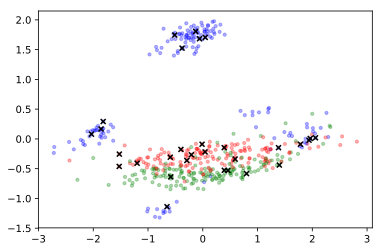

Iteration: 100 sigma_noise: 1.408, sigma_f: 0.970, length_scale: 0.522, free_energy: -773.961


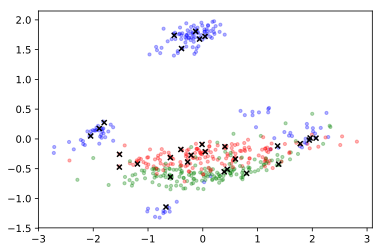

Iteration: 200 sigma_noise: 0.901, sigma_f: 1.011, length_scale: 0.700, free_energy: -621.753


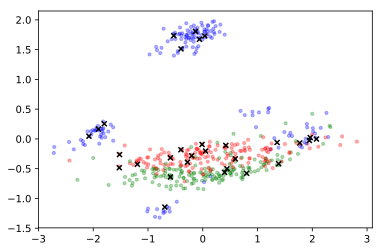

Iteration: 300 sigma_noise: 0.759, sigma_f: 1.108, length_scale: 0.795, free_energy: -590.238


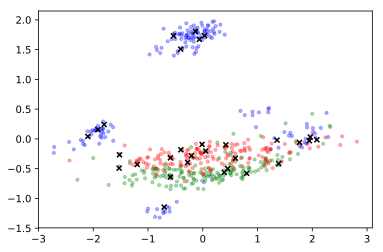


Optimising the latent variables...


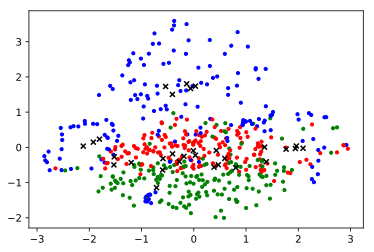

Log-likelihood (iteration 1): -40889.772


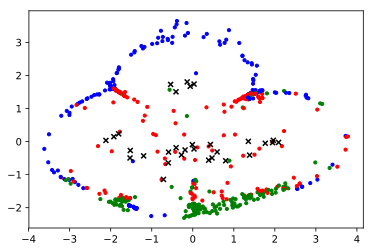

Log-likelihood (iteration 51): -2816.541


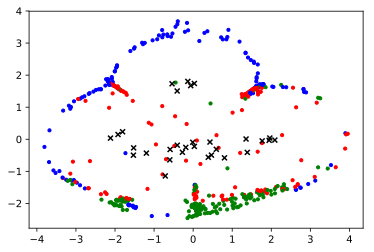

Log-likelihood (iteration 101): -2204.579


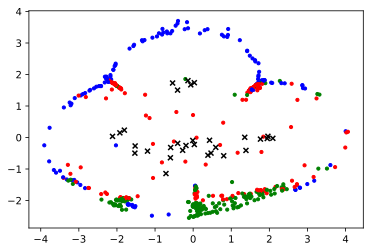

Log-likelihood (iteration 151): -2029.769
Final log-likelihood: -1935.911



Iteration 2


Optimising inducing points...


Iteration: 0 sigma_noise: 2.759, sigma_f: 0.984, length_scale: 0.368, free_energy: -1561.982


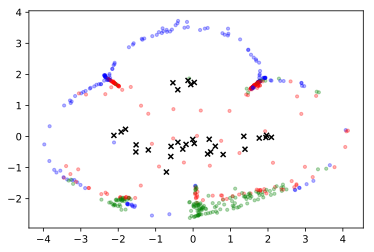

Iteration: 100 sigma_noise: 3.342, sigma_f: 0.557, length_scale: 0.370, free_energy: -1295.278


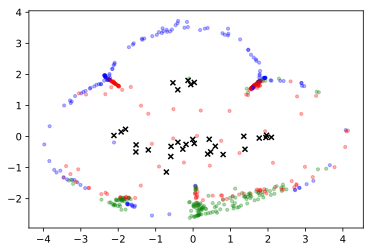

Iteration: 200 sigma_noise: 3.083, sigma_f: 0.426, length_scale: 0.371, free_energy: -1255.695


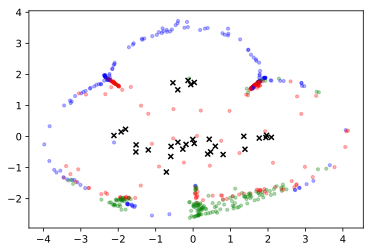

Iteration: 300 sigma_noise: 2.915, sigma_f: 0.350, length_scale: 0.372, free_energy: -1234.979


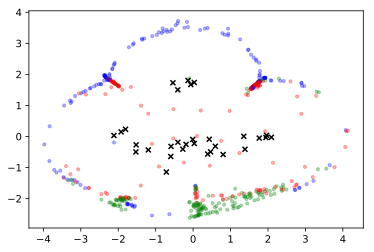


Optimising the latent variables...


Early convergence at iteration 0!



In [12]:
# Set seed for reproducibility
np.random.seed(42)


X, X_m, sigma_noise, sigma_f, length_scale = fit(Y, 
                                            latent_dim, 
                                            labels,
                                            num_inducing_points=30,
                                            num_E_iter=400, 
                                            num_M_iter=200,
                                            num_iter=2, 
                                            learn_rate=1e-5, 
                                            verbose=False)

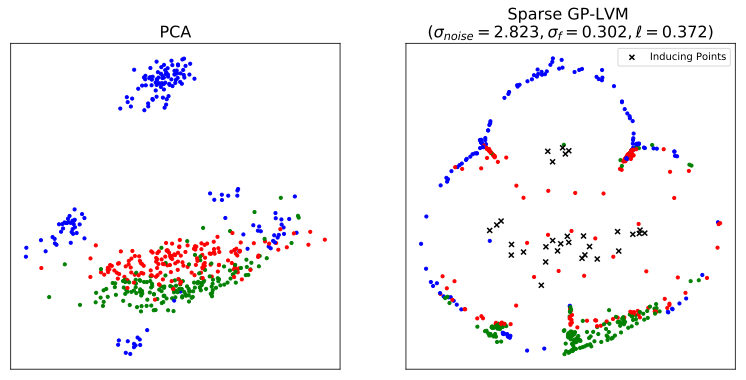

In [17]:
plt.figure(figsize = (13, 6))
plt.subplot(121)
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(Y)
X_pca = X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('PCA', fontsize=16)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('Sparse GP-LVM \n($\\sigma_{{noise}} = {:.3f}, \\sigma_f = {:.3f}, \\ell = {:.3f}$)'.format(sigma_noise, 
                                                                      sigma_f, 
                                                                      length_scale), fontsize=16)
plt.scatter(X_m[:, 0], X_m[:, 1], s=25, c='k', marker='x', label="Inducing Points")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig(IMG_FOLDER +'/sparse_clustered.png')
plt.show()